# Python implementation with genetic algoritm

```{custom_download_link} https://surfdrive.surf.nl/files/index.php/s/8DNGkJs54KzEnLB/download
:text: "All code + datasets"
:replace_default: "True"
```

```{note}
Gurobi cannot be loaded in this online book, so download this notebook to work on it with Gurobi locally installed. You can make use of environment which is provided with the [code and dataset](https://surfdrive.surf.nl/files/index.php/s/8DNGkJs54KzEnLB/download), make sure you activate your Gurobi license. Instruction on how to do that are in the `README.md` and `PA_2_4_A_gurobilicious.ipynb` of week 2.4.
```

```{admonition} MUDE Exam Information
:class: tip, dropdown
The road network design problem serves as an example for solving a complex optimization problem. You're not expected to understand the problem details for the exam.
```

## Data preprocessing

Our data preprocessing steps are similar to the previous notebook. We use some networks from the well-known transportation networks for benchmarking repository as well as a small toy network for case studies of NDPs. The following functions read data from this repository and perform data preprocessing to have the input and the parameters required for our case studies.

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

# Genetic algorithm dependencies. We are importing the pymoo functions that are imporant for applying GA (the package can also apply other methods)
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation

# not used here but generally useful dependencies
#from pymoo.core.problem import Problem
#from pymoo.operators.mutation.pm import PolynomialMutation
#from pymoo.operators.crossover.pntx import PointCrossover
#from pymoo.operators.crossover.sbx import SBX
#from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
#from pymoo.operators.crossover.pntx import Crossover
#from pymoo.operators.repair.bounds_repair import BoundsRepair
#from pymoo.core.repair import Repair

In [2]:
# For visualization
from utils.network_visualization import network_visualization
from utils.network_visualization_highlight_link import network_visualization_highlight_links
from utils.network_visualization_upgraded import network_visualization_upgraded

In [3]:
# import required packages
import os
import time

# read network file
def read_net(net_file):
    """
       read network file
    """

    net_data = pd.read_csv(net_file, skiprows=8, sep='\t')
    # make sure all headers are lower case and without trailing spaces
    trimmed = [s.strip().lower() for s in net_data.columns]
    net_data.columns = trimmed
    # And drop the silly first and last columns
    net_data.drop(['~', ';'], axis=1, inplace=True)

    # make sure everything makes sense (otherwise some solvers throw errors)
    net_data.loc[net_data['free_flow_time'] <= 0, 'free_flow_time'] = 1e-6
    net_data.loc[net_data['capacity'] <= 0, 'capacity'] = 1e-6
    net_data.loc[net_data['length'] <= 0, 'length'] = 1e-6
    net_data.loc[net_data['power'] <= 1, 'power'] = int(4)
    net_data['init_node'] = net_data['init_node'].astype(int)
    net_data['term_node'] = net_data['term_node'].astype(int)
    net_data['b'] = net_data['b'].astype(float)

    # extract features in dict format
    links = list(zip(net_data['init_node'], net_data['term_node']))
    caps = dict(zip(links, net_data['capacity']))
    fftt = dict(zip(links, net_data['free_flow_time']))
    lent = dict(zip(links, net_data['length']))
    alpha = dict(zip(links, net_data['b']))
    beta = dict(zip(links, net_data['power']))

    net = {'capacity': caps, 'free_flow': fftt, 'length': lent, 'alpha': alpha, 'beta': beta}

    return net


# read OD matrix (demand)
def read_od(od_file):
    """
       read OD matrix
    """

    f = open(od_file, 'r')
    all_rows = f.read()
    blocks = all_rows.split('Origin')[1:]
    matrix = {}
    for k in range(len(blocks)):
        orig = blocks[k].split('\n')
        dests = orig[1:]
        origs = int(orig[0])

        d = [eval('{' + a.replace(';', ',').replace(' ', '') + '}') for a in dests]
        destinations = {}
        for i in d:
            destinations = {**destinations, **i}
        matrix[origs] = destinations
    zones = max(matrix.keys())
    od_dict = {}
    for i in range(zones):
        for j in range(zones):
            demand = matrix.get(i + 1, {}).get(j + 1, 0)
            if demand:
                od_dict[(i + 1, j + 1)] = demand
            else:
                od_dict[(i + 1, j + 1)] = 0

    return od_dict


# read case study data
def read_cases(networks, input_dir):
    """
       read case study data
    """

    # dictionaries for network and OD files
    net_dict = {}
    ods_dict = {}

    # selected case studies
    if networks:
        cases = [case for case in networks]
    else:
        # all folders available (each one for one specific case)
        cases = [x for x in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, x))]

    # iterate through cases and read network and OD
    for case in cases:
        mod = os.path.join(input_dir, case)
        mod_files = os.listdir(mod)
        for i in mod_files:
            # read network
            if i.lower()[-8:] == 'net.tntp':
                net_file = os.path.join(mod, i)
                net_dict[case] = read_net(net_file)
            # read OD matrix
            if 'TRIPS' in i.upper() and i.lower()[-5:] == '.tntp':
                ods_file = os.path.join(mod, i)
                ods_dict[case] = read_od(ods_file)

    return net_dict, ods_dict


# create node-destination demand matrix
def create_nd_matrix(ods_data, origins, destinations, nodes):
    # create node-destination demand matrix (not a regular OD!)
    demand = {(n, d): 0 for n in nodes for d in destinations}
    for r in origins:
        for s in destinations:
            if (r, s) in ods_data:
                demand[r, s] = ods_data[r, s]
    for s in destinations:
        demand[s, s] = - sum(demand[j, s] for j in origins)

    return demand


Now that we have the required functions for reading and processing the data, let's define some problem parameters and prepare the input.

In [4]:
# define parameters, case study (network) list and the directory where their files are
extension_factor = 1.5  # capacity after extension (1.5 means add 50%)
extension_max_no = 20  # the number of links to add capacity to (simplified way of reprsenting a budget for investing)
#it's the same to say that it's exactly this number of that this number is the max, that's because every investment brings travel time benefits 
#even if just one car circulates.
timelimit = 300 # seconds
beta = 2  # parameter to use in link travel time function (explained later)

networks = ['SiouxFalls']
networks_dir = os.getcwd() +'/input/TransportationNetworks'


# prep data
net_dict, ods_dict = read_cases(networks, networks_dir)

# Let's load the network and demand (OD matrix) data of the first network (Sioux Falls) to two dictionaries for our first case study.
# WE USE THE SAME NETWORK FROM THE FIRST NOTEBOOK: SIOUX FALLS
# The network has 76 arcs in total
net_data, ods_data = net_dict[networks[0]], ods_dict[networks[0]]

## now let's prepare the data in a format readable by gurobi

# prep links, nodes, and free flow travel times
links = list(net_data['capacity'].keys())
nodes = np.unique([list(edge) for edge in links])
fftts = net_data['free_flow']

# auxiliary parameters (dict format) to keep the problem linear (capacities as parameters rather than variables)
cap_normal = {(i, j): cap for (i, j), cap in net_data['capacity'].items()}
cap_extend = {(i, j): cap * extension_factor for (i, j), cap in net_data['capacity'].items()}

# origins and destinations
dests = np.unique([dest for (orig, dest) in list(ods_data.keys())])
origs = np.unique([orig for (orig, dest) in list(ods_data.keys())])

# demand in node-destination form
demand = create_nd_matrix(ods_data, origs, dests, nodes)

C:\Users\tomvanwoudenbe\AppData\Local\Temp\ipykernel_26868\123191696.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  net_data.loc[net_data['free_flow_time'] <= 0, 'free_flow_time'] = 1e-6
C:\Users\tomvanwoudenbe\AppData\Local\Temp\ipykernel_26868\123191696.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  net_data.loc[net_data['length'] <= 0, 'length'] = 1e-6
C:\Users\tomvanwoudenbe\AppData\Local\Temp\ipykernel_26868\123191696.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1e-06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  net_

### Network Display
We will use the same function we used in the previous notebook to visualize the network. 

In [5]:
coordinates_path = 'input/TransportationNetworks/SiouxFalls/SiouxFallsCoordinates.geojson'

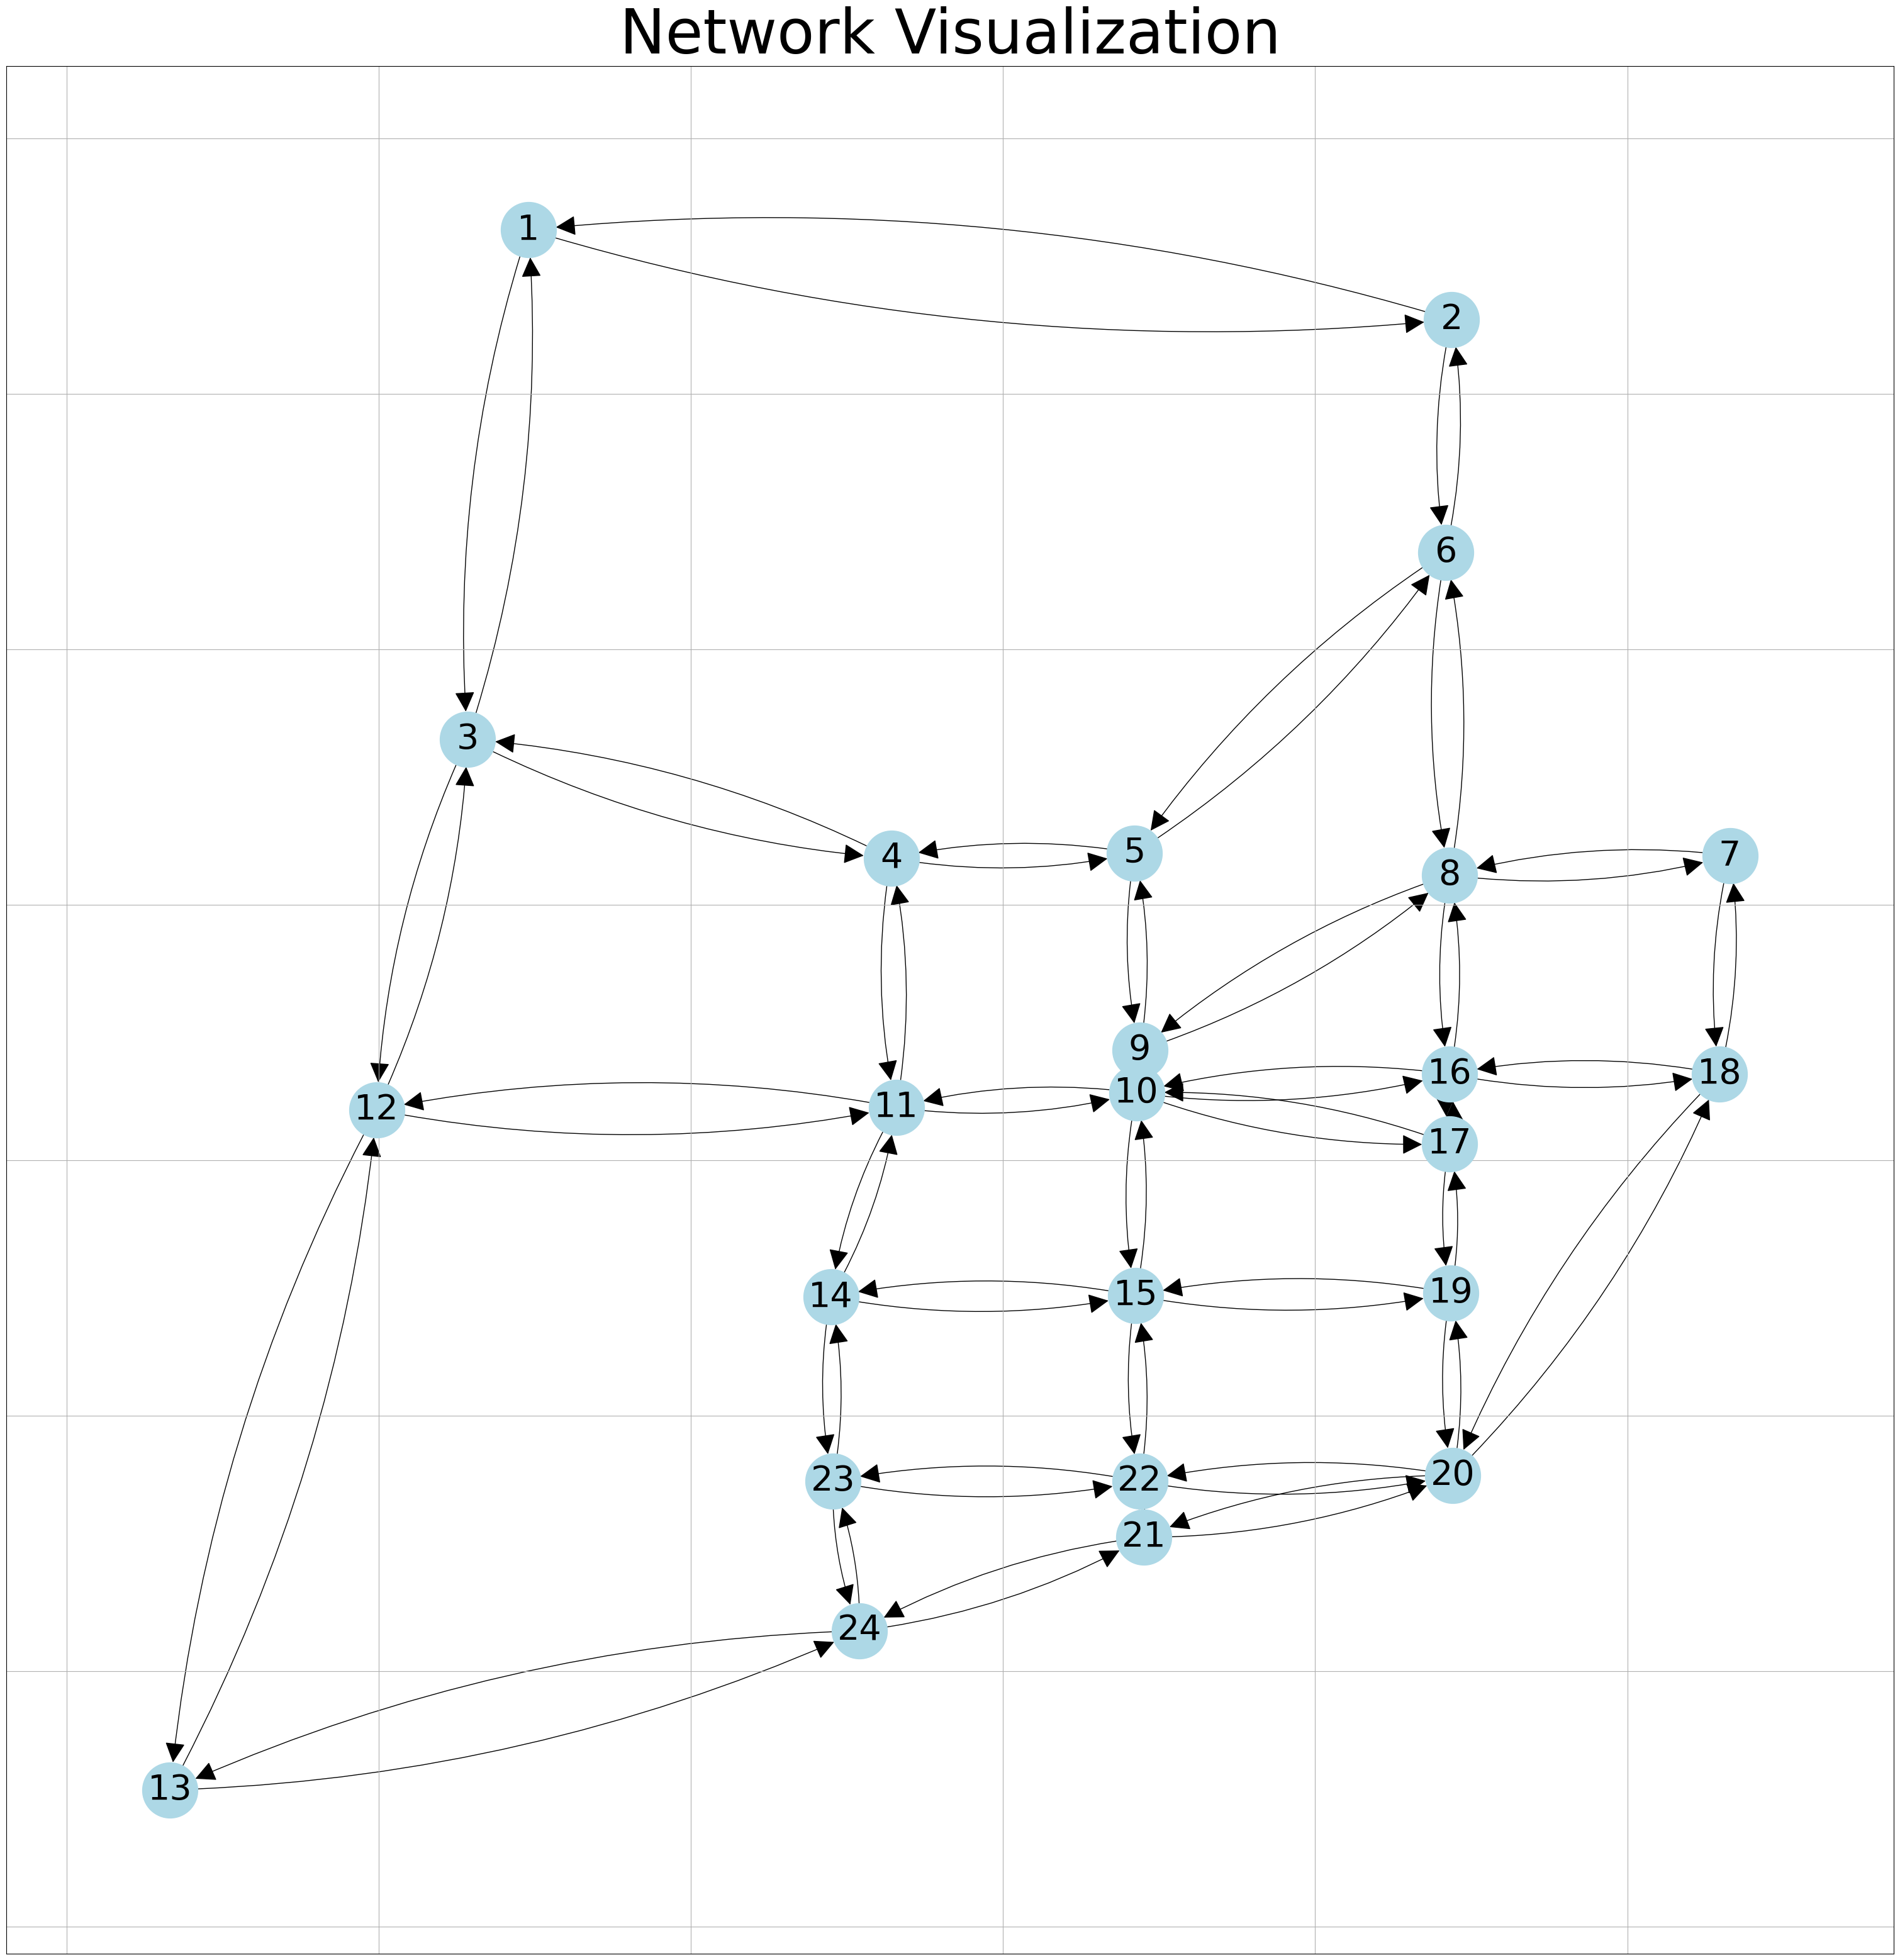

In [6]:
G, pos = network_visualization(link_flow = fftts,coordinates_path= coordinates_path) # the network we create here will be used later for further visualizations!

Now we are ready to build our models!

## Modeling and solving the traffic assignment sub-problem with Gurobi

In this section we build a Gurobi model to solve the Traffic Assignment sub-problems. The decision variables, objective function, and the constraints of this problem were described before.
Here we wrap the code in a function so that we can use it later within the GA.

In [7]:
def ta_qp(dvs, net_data=net_data, ods_data=ods_data, extension_factor=1.5):

    # prep variables
    beta = 2
    links = list(net_data['capacity'].keys())
    nodes = np.unique([list(edge) for edge in links])
    fftts = net_data['free_flow']
    links_selected = dict(zip(links, dvs))

    # define capacity
    cap_normal = {(i, j): cap for (i, j), cap in net_data['capacity'].items()}
    cap_extend = {(i, j): cap * extension_factor for (i, j), cap in net_data['capacity'].items()}
    capacity = {(i, j): cap_normal[i, j] * (1 - links_selected[i, j]) + cap_extend[i, j] * links_selected[i, j]
                for (i, j) in links}

    dests = np.unique([dest for (orig, dest) in list(ods_data.keys())])
    origs = np.unique([orig for (orig, dest) in list(ods_data.keys())])

    # demand in node-destination form
    demand = create_nd_matrix(ods_data, origs, dests, nodes)

    ## create a gurobi model object
    model = gp.Model()
    # just to avoid cluttering the notebook with unnecessary logging output
    model.Params.LogToConsole = 0

    ## decision variables:

    # link flows (x_ij); i: a_node, j: b_node
    link_flow = model.addVars(links, vtype=gp.GRB.CONTINUOUS, name='x')

    # link flows per destination (xs_ijs); i: a_node, j: b_node, s: destination
    dest_flow = model.addVars(links, dests, vtype=gp.GRB.CONTINUOUS, name='xs')

    ## constraints

    # node flow conservation (demand)
    model.addConstrs(
        gp.quicksum(dest_flow[i, j, s] for j in nodes if (i, j) in links) -
        gp.quicksum(dest_flow[j, i, s] for j in nodes if (j, i) in links) == demand[i, s]
        for i in nodes for s in dests
    )

    # link flow conservation (destination flows and link flows)
    model.addConstrs(gp.quicksum(dest_flow[i, j, s] for s in dests) == link_flow[i, j] for (i, j) in links)

    ## objective function (total travel time)
    # total travel time = sum (link flow * link travel time)
    # link travel time = free flow travel time * (1 + (flow / capacity))

    model.setObjective(
        gp.quicksum(link_flow[i, j] * (fftts[i, j] * (1 + (beta * link_flow[i, j]/capacity[i, j]))) for (i, j) in links))


    ## solve
    model.update()
    start_solve = time.time()
    model.optimize()
    solve_time = (time.time() - start_solve)

    # fetch optimal DV and OF values
    link_flows = {(i, j): link_flow[i, j].X for (i, j) in links}
    total_travel_time = model.ObjVal

    return total_travel_time, capacity, link_flows, links_selected

## Modeling with PyMOO

Let's define a model in MyMOO and deal with the links selection problem with the GA.

First, we need to define a problem class.

In [8]:
#If you want to know more about the library that is being used: https://pymoo.org/algorithms/soo/ga.html

class NDP(ElementwiseProblem):

    def __init__(self, budget):

        super().__init__(n_var=len(links),       # number of decision variables (i.e., number of links)
                         n_obj=1,                # for now we use only one objective (total travel time)
                         n_constr=1,             # one constraint for budget, that's because the GA shoud not create unfeasible solutions
                         vtype=bool,             # binary decision variables
                        )
        self.budget = budget

    def _evaluate(self, decision_vars, out, *args, **kwargs):

        # call TA to calculate the objective fucntion, meaning to do the evaluation of the solutions
        total_travel_time,capacity, link_flows, links_selected = ta_qp(decision_vars)

        # the budget constraint
        # In the GA part the only variables are the binary decision variables, don't forget that the traffic assignment that 
        # produces the travel time on the network is done in the evaluation of the solution
        g = sum(decision_vars) - self.budget

        out["F"] = total_travel_time
        out["G"] = g

Now, let's initiate an instance of the problem based on the problem class we defined, and initiate the GA with its parameters. Note that depending on the problem size and the number of feasible links, you might need larger values for population and generation size to achieve good results or even feasible results. Of course this increases the computation times.

:::{card} Test yourself
<iframe src="https://tudelft.h5p.com/content/1292134770357348867/embed" aria-label="Project question 5" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>
:::

In [9]:
Budget = 76
pop_size = 10

# initiate an instance of the problem with max number of selected links as budget constraint
problem = NDP(budget=Budget)

# initiate the GA with parameters appropriate for binary variables
method = GA(pop_size=pop_size,
            sampling=BinaryRandomSampling(),
            mutation=BitflipMutation(),
            crossover=HalfUniformCrossover()
            )

## Solve the problem 
Now we are ready to minimize the NDP problem using the GA method we defined.

In [10]:

opt_results = minimize(problem,
               method,
               termination=("time", "00:05:00"), #5 minute maximum computation time
               seed=7,
               save_history=True,
               verbose=True,
               )

print("Best Objective Function value: %s" % opt_results.F)
print("Constraint violation: %s" % opt_results.CV)
print("Best solution found: %s" % opt_results.X)

#To better interpret the results, this is the legend:
#n_gen:  Number of generations
#n_eval: Number of function evaluations
#cv_min: Minimum constraint violation
#cv_avg: Average constraint violation
#f_avg:  Average objective function value
#f_min:  Minimum objective function value

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-30
n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       10 |  0.000000E+00 |  0.000000E+00 |  1.133603E+07 |  1.099320E+07
     2 |       20 |  0.000000E+00 |  0.000000E+00 |  1.115345E+07 |  1.099320E+07
     3 |       30 |  0.000000E+00 |  0.000000E+00 |  1.101778E+07 |  1.092529E+07
     4 |       40 |  0.000000E+00 |  0.000000E+00 |  1.094030E+07 |  1.072021E+07
     5 |       50 |  0.000000E+00 |  0.000000E+00 |  1.080675E+07 |  1.068791E+07
     6 |       60 |  0.000000E+00 |  0.000000E+00 |  1.069495E+07 |  1.061269E+07
     7 |       70 |  0.000000E+00 |  0.000000E+00 |  1.062946E+07 |  1.049909E+07
     8 |       80 |  0.000000E+00 |  0.000000E+00 |  1.058418E+07 |  1.049909E+07
     9 |       90 |  0.000000E+00 |  0.000000E+00 |  1.049891E+07 |  1.042237E+07
    10 |      100 |  0.000000E+00 |  0.000000E+00 |  1.046506E+07 |  1.038920E+07
    11 

## Convergence curve

Let's first define some functions (to use later) to get the results and plot them.

In [11]:
def get_results(opt_results):

    number_of_individuals = [] # The number of individuals in each generation
    optimal_values_along_generations = []  # The optimal value found in each generation

    for generation_status in opt_results.history:

        # retrieve the optimum from the algorithm
        optimum = generation_status.opt

        # filter out only the feasible solutions and append and objective space values
        try:
            feas = np.where(optimum.get("feasible"))[0]
            optimal_values_along_generations.append(optimum.get("F")[feas][0][0])
            # store the number of function evaluations
            number_of_individuals.append(generation_status.evaluator.n_eval)
        except:
            #In case a generation does not have any feasible solutions, it will be ignored.
            pass

    return number_of_individuals, optimal_values_along_generations


def plot_results(number_of_individuals, optimal_values_along_generations):

    # Create a scatter plot with enhanced styling
    plt.figure(figsize=(8, 6))  # Set the figure size

    # Create a scatter plot
    plt.scatter(number_of_individuals, optimal_values_along_generations, label='Best objective function', color='blue', marker='o', s=100, alpha=0.7, edgecolors='black', linewidths=1.5)

    # Add labels and a legend with improved formatting
    plt.xlabel('Function evaluations', fontsize=14, fontweight='bold')
    plt.ylabel('Total Travel Time', fontsize=14, fontweight='bold')
    plt.title('Best solution evolution', fontsize=16, fontweight='bold')
    plt.legend(loc='upper right', fontsize=12)

    # Customize the grid appearance
    plt.grid(True, linestyle='--', alpha=0.5)

    # Customize the tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add a background color to the plot
    plt.gca().set_facecolor('#f2f2f2')

    # Show the plot
    plt.show()

Now let's use these functions to plot the results.


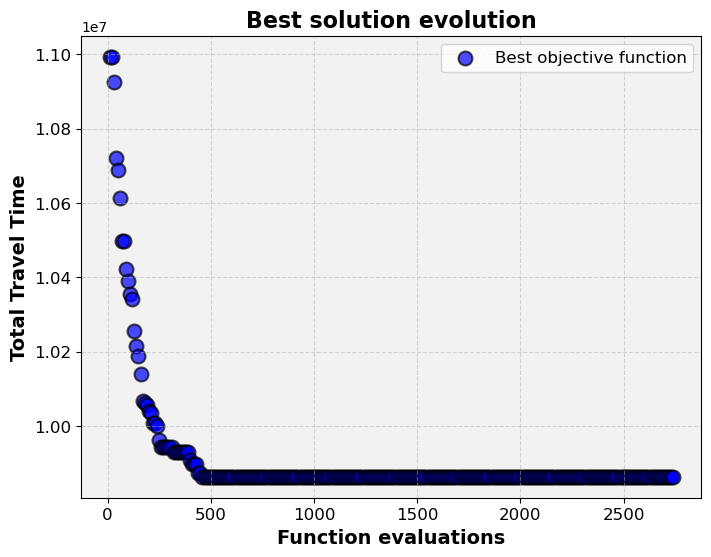

In [12]:
number_of_individuals, optimal_values_along_generations = get_results(opt_results)

plot_results(number_of_individuals, optimal_values_along_generations)

## Network Visualization
Same as the previous notebook we use link_flows, links_selected to visualize our results on the network.

In [13]:
travel_time, capacity, link_flows, links_selected= ta_qp(dvs=opt_results.X, net_data=net_data, ods_data=ods_data, extension_factor=1.5)

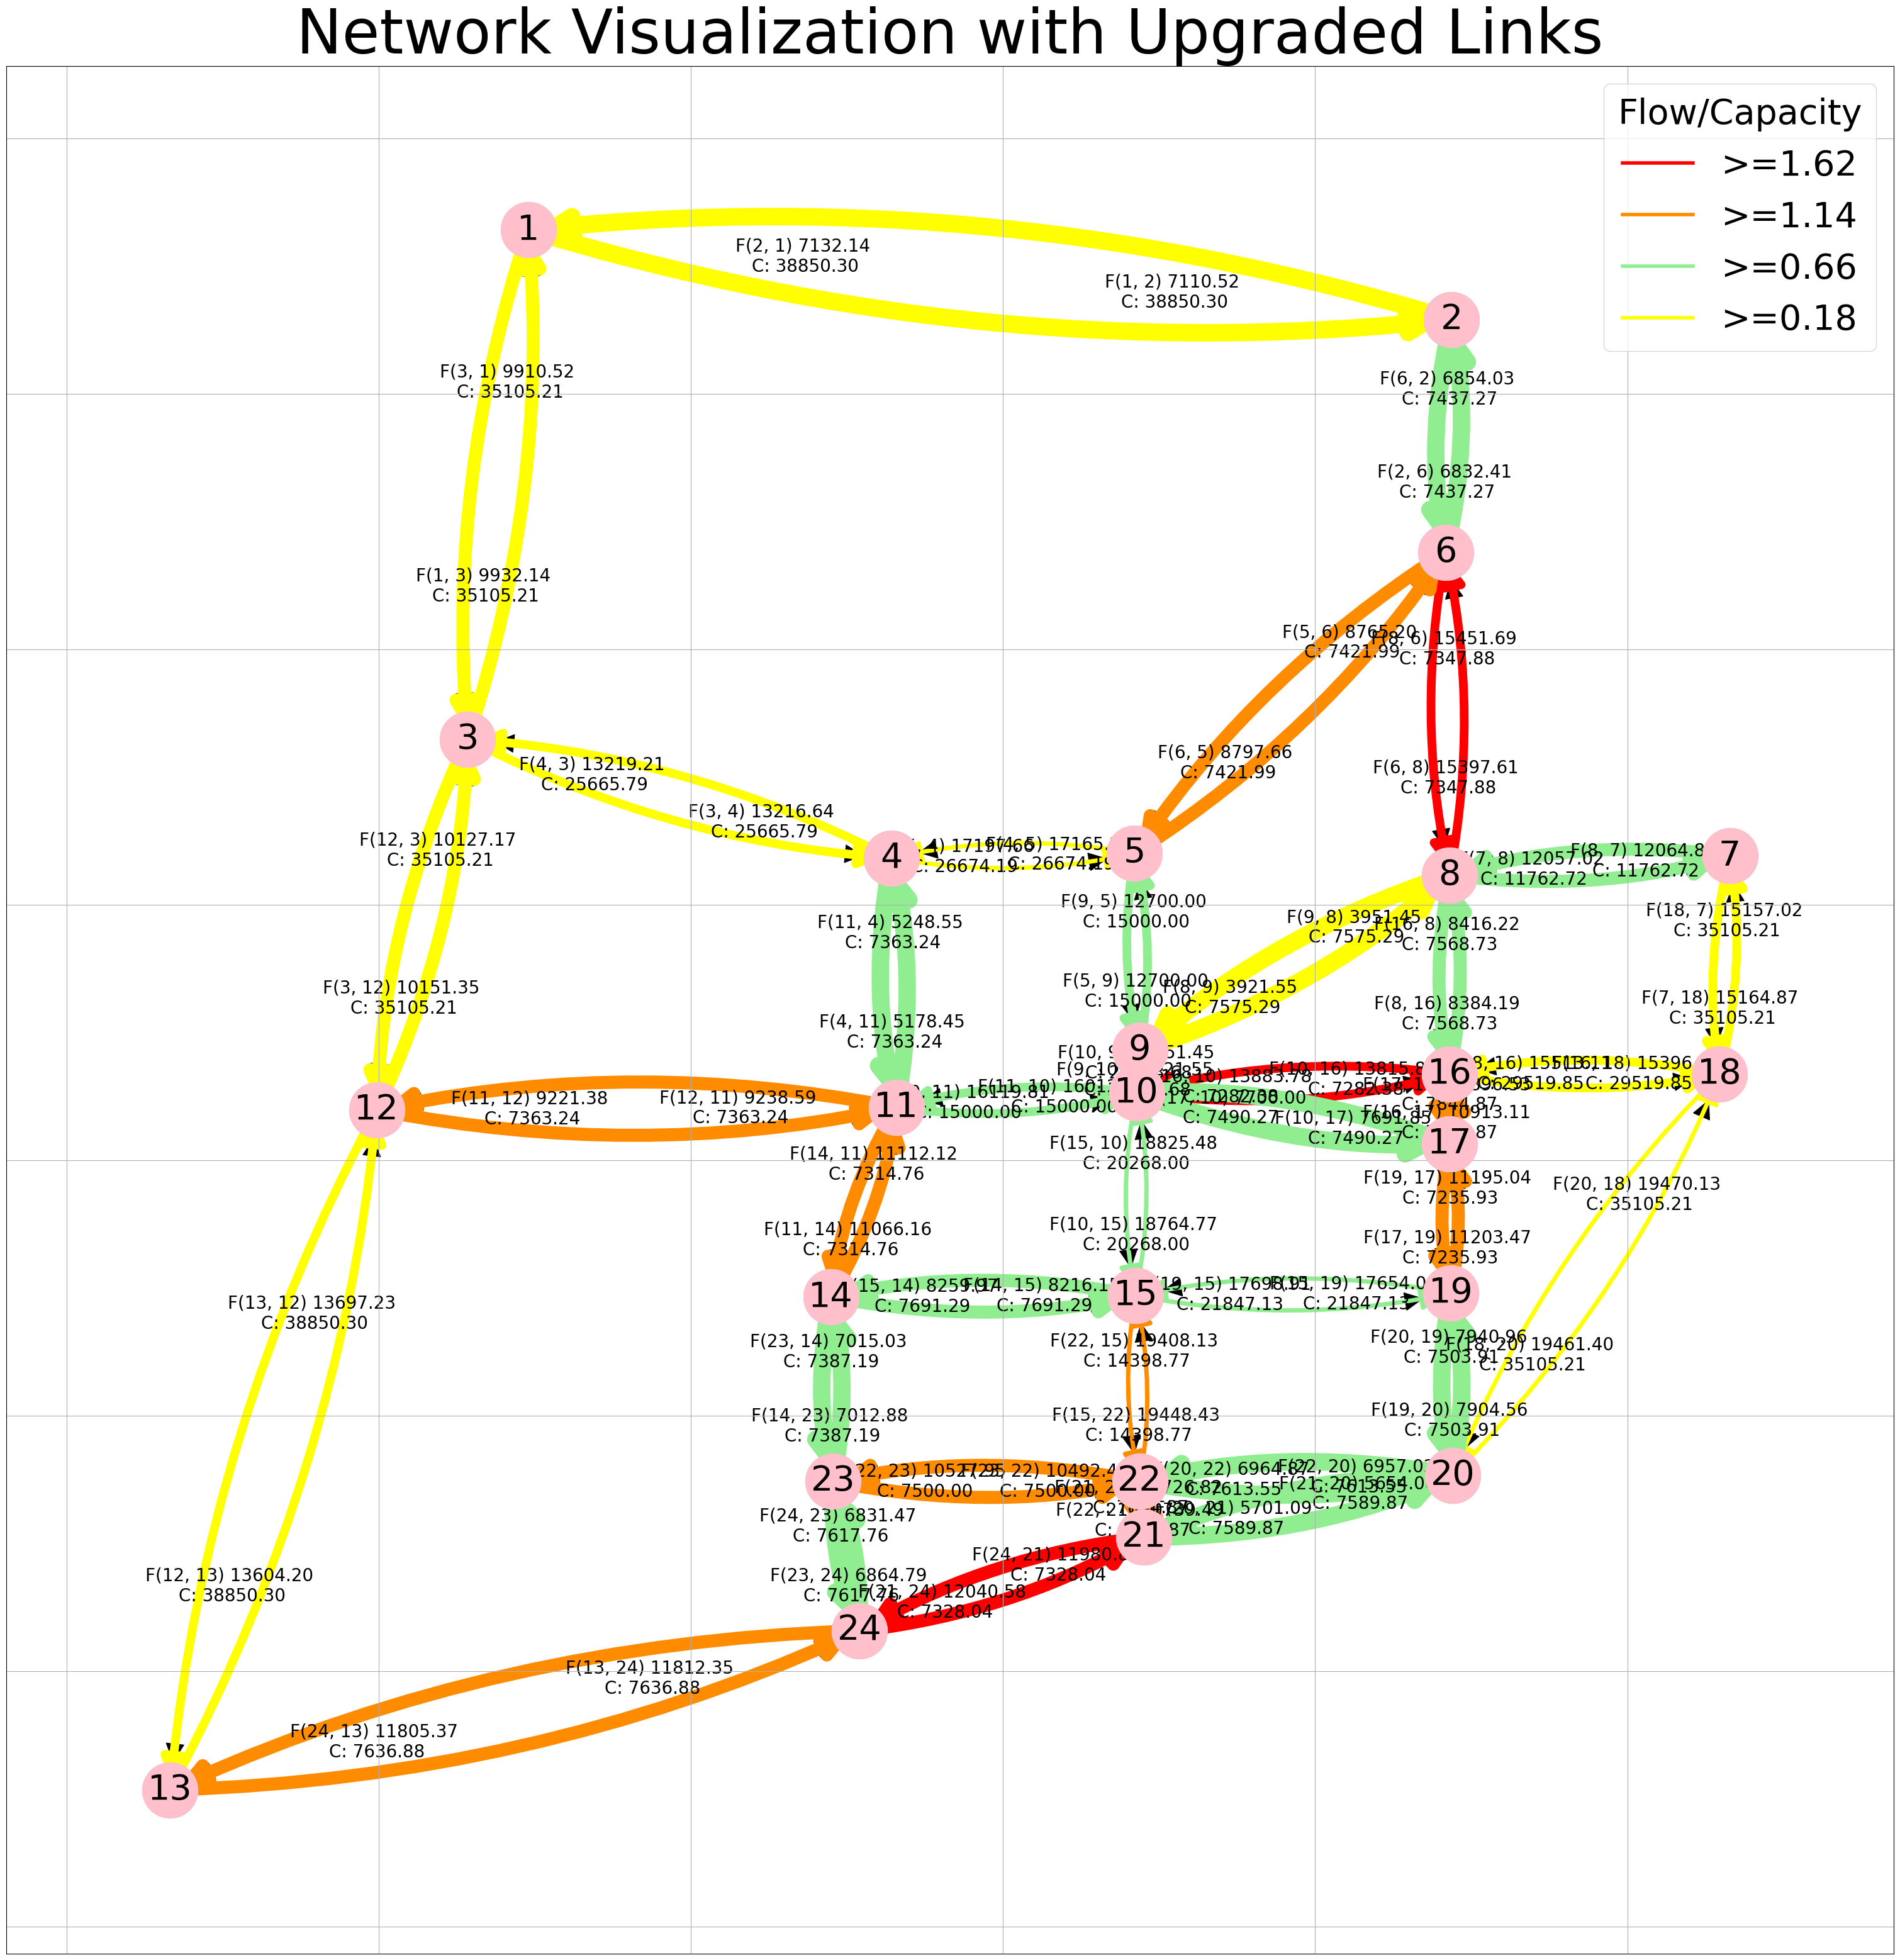

In [14]:
# Plot results
# To see the values for all the links just turn on the labels in the function below.
network_visualization_upgraded (G = G, pos=pos, link_flow=link_flows, capacity_new=capacity ,link_select=links_selected, labels='off')